In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_excel("data/cases_2021_train_processed_2.xlsx")
test_data = pd.read_excel("data/cases_2021_test_processed_unlabelled_2.xlsx")

# 1.1 Feature Selection

In [24]:
train = train_data.copy()
train = train[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio','outcome_group']]
test = test_data.copy()
test = test[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio']]
train_data, test_data = train,test 

# 1.2 Feature Mapping

In [25]:
train = train_data.copy()
train['country'] = pd.factorize(train['country'])[0]
train['chronic_disease_binary'] = pd.factorize(train['chronic_disease_binary'])[0]
new_label = {"outcome_group": {"deceased": 0, "hospitalized": 1, "nonhospitalized": 2}}
train.replace(new_label, inplace = True)
test = test_data.copy()
test['country'] = pd.factorize(test['country'])[0]
test['chronic_disease_binary'] = pd.factorize(test['chronic_disease_binary'])[0]
train_data, test_data = train,test 

# 1.3 Balancing Classes


Before Balancing,
outcome_group
0      997
1    13241
2     2974
dtype: int64


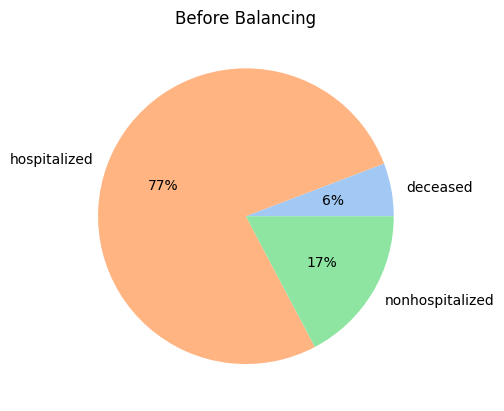


After Balancing,
outcome_group
0     9970
1    10569
2     9814
dtype: int64


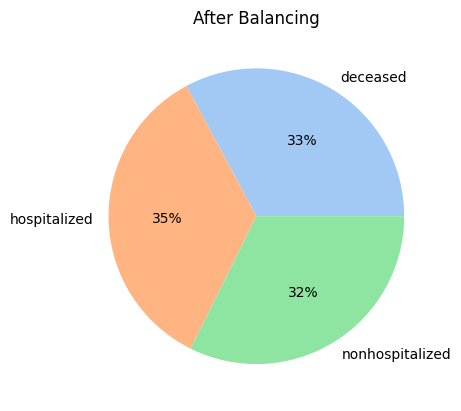

In [26]:
def show_train_dataset_pie_chart(train_dataset: pd.DataFrame, title: str):
    plt.figure()
    data = train_dataset.groupby("outcome_group").size()
    print("\n" + title + ",")
    print(data)
    data = [int(data[0]), int(data[1]), int(data[2])]
    labels = ["deceased", "hospitalized", "nonhospitalized"]
    colours = sns.color_palette('pastel')[0:4]
    plt.pie(x=data, labels=labels, colors=colours, autopct='%.0f%%')
    plt.title(title)
    plt.show()

show_train_dataset_pie_chart(train_data, "Before Balancing")

deceased = train_data[train_data["outcome_group"] == 0]
new_deceased = deceased.sample(frac=10, replace=True, random_state=1)
new_deceased.reset_index(inplace=True, drop=True)

hospitalized = train_data[train_data["outcome_group"] == 1]
hospitalized_sample = np.random.choice(hospitalized.index, 3000, replace=True)
new_hospitalized = hospitalized.drop(hospitalized_sample)
new_hospitalized.reset_index(inplace=True, drop=True)

nonhospitalized = train_data[train_data["outcome_group"] == 2]
new_nonhospitalized = nonhospitalized.sample(frac=3.3, replace=True, random_state=1)
new_nonhospitalized.reset_index(inplace=True, drop=True)

new_train = pd.concat([new_deceased, new_hospitalized, new_nonhospitalized])
new_train.sort_index(axis = 0, inplace=True)
new_train.reset_index(inplace=True, drop=True)

show_train_dataset_pie_chart(new_train, "After Balancing")

train_data = new_train

# 1.4 Building Models

### Train/Validation Split,

In [27]:
train_data, validation_data = train_test_split(train_data, test_size=0.2)

### XG Boost,

In [13]:
# Takes about 1 - 2 minutes to run.

# Decide number of k-fold splits
k = 5
# Create model with blank parameters
xgb_model = xgb.XGBClassifier(random_state = 1)
# Create space of possible parameters
parameter_search_space = {
    "learning_rate": [0.2, 0.3],
    "max_depth": [6, 8, 10],
    "n_estimators": [150, 250],
    "objective": ["multi:softmax"],
    "num_class": [3]
}
# Create grid search cross validation object
grid_search_cv = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameter_search_space,
    scoring="f1_macro",
    cv=k,
    verbose=10
)
# Put data and labels in proper format
data = train_data.iloc[:, :4].values
labels = train_data.iloc[:, 4].values.reshape(-1, 1)
# Fit grid search object
grid_search_cv.fit(data, labels)
# Print and save results.
print("XG Boost GridSearchCV best score = " + str(grid_search_cv.best_score_))
print("XG Boost GridSearchCV best parameters = " + str(grid_search_cv.best_params_))
predictions = grid_search_cv.predict(data)
_, _, fscore, _ = precision_recall_fscore_support(predictions, labels)
print("XG Boost GridSearchCV deceased class f1-score = " + str(fscore[0]))
accuracy = accuracy_score(predictions, labels)
print("XG Boost GridSearchCV accuracy score = " + str(accuracy))
pd.DataFrame(grid_search_cv.cv_results_).to_csv("xgboost_results.csv")
xgb_model = grid_search_cv.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 1/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.814 total time=   0.5s
[CV 2/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 2/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.809 total time=   0.5s
[CV 3/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 3/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.814 total time=   0.5s
[CV 4/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 4/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objectiv

### Random Forest,

In [14]:
# Takes about 3-4 minutes to run.

# Decide number of k-fold splits
k = 5
# Create model with blank parameters
rf_model = RandomForestClassifier(random_state = 44)
# Create space of possible parameters
parameter_search_space = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ["gini", "entropy"],
    'max_features': [1, 2, 3, 4]
  }
# Create grid search cross validation object
grid_search_cv = GridSearchCV(
    estimator=rf_model,
    param_grid=parameter_search_space,
    scoring="f1_macro",
    cv=k,
    verbose=10
)
# Put data and labels in proper format
data = train_data.iloc[:, :4].values
labels = train_data.iloc[:, 4].values.ravel()
# Fit grid search object
grid_search_cv.fit(data, labels)
# Print and save results.
print("Random Forest GridSearchCV best score = " + str(grid_search_cv.best_score_))
print("Random Forest GridSearchCV best parameters = " + str(grid_search_cv.best_params_))
predictions = grid_search_cv.predict(data)
_, _, fscore, _ = precision_recall_fscore_support(predictions, labels)
print("Random Forest GridSearchCV deceased class f1-score = " + str(fscore[0]))
accuracy = accuracy_score(predictions, labels)
print("Random Forest GridSearchCV accuracy score = " + str(accuracy))
pd.DataFrame(grid_search_cv.cv_results_).to_csv("rf_results.csv")
rf_model = grid_search_cv.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START criterion=gini, max_features=1, n_estimators=50............
[CV 1/5; 1/32] END criterion=gini, max_features=1, n_estimators=50;, score=0.816 total time=   0.2s
[CV 2/5; 1/32] START criterion=gini, max_features=1, n_estimators=50............
[CV 2/5; 1/32] END criterion=gini, max_features=1, n_estimators=50;, score=0.808 total time=   0.2s
[CV 3/5; 1/32] START criterion=gini, max_features=1, n_estimators=50............
[CV 3/5; 1/32] END criterion=gini, max_features=1, n_estimators=50;, score=0.819 total time=   0.2s
[CV 4/5; 1/32] START criterion=gini, max_features=1, n_estimators=50............
[CV 4/5; 1/32] END criterion=gini, max_features=1, n_estimators=50;, score=0.811 total time=   0.2s
[CV 5/5; 1/32] START criterion=gini, max_features=1, n_estimators=50............
[CV 5/5; 1/32] END criterion=gini, max_features=1, n_estimators=50;, score=0.805 total time=   0.2s
[CV 1/5; 2/32] START criterion=gi

### MLP Classifier

In [15]:
# Takes about 12 minutes to run.

from sklearn.neural_network import MLPClassifier
# x_train = train_data[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio']]
# y_train = train_data[['outcome_group']]
mlp_gs = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

data = train_data.iloc[:, :4].values
labels = train_data.iloc[:, 4].values.reshape(-1, 1)
grid_search_cv = GridSearchCV(
    estimator=mlp_gs,
    param_grid=parameter_space,
    scoring="f1_macro",
    cv=5,
    verbose=10
)
grid_search_cv.fit(data,labels.ravel())

print("MLP Classifier GridSearchCV best score = " + str(grid_search_cv.best_score_))
print("MLP Classifier GridSearchCV best parameters = " + str(grid_search_cv.best_params_))
predictions = grid_search_cv.predict(data)
_, _, fscore, _ = precision_recall_fscore_support(predictions, labels)
print("MLP Classifier GridSearchCV deceased class f1-score = " + str(fscore[0]))
accuracy = accuracy_score(predictions, labels)
print("MLP Classifier GridSearchCV accuracy score = " + str(accuracy))
pd.DataFrame(grid_search_cv.cv_results_).to_csv("MLP Classifier_results.csv")
mlp_gs = grid_search_cv.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 1/5; 1/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.409 total time=   1.1s
[CV 2/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 2/5; 1/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.740 total time=   4.7s
[CV 3/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 3/5; 1/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.741 total time=   7.7s
[CV 4/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 4

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 2/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam;, score=0.765 total time=  10.3s
[CV 3/5; 2/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam
[CV 3/5; 2/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam;, score=0.754 total time=   5.4s
[CV 4/5; 2/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam
[CV 4/5; 2/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam;, score=0.765 total time=   9.7s
[CV 5/5; 2/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam
[CV 5/5; 2/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam;, score=0.756 total time=   3.6s
[CV 1/5; 3/32] START activati

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.772 total time=   9.1s
[CV 2/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.760 total time=   8.9s
[CV 3/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 3/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.768 total time=   8.6s
[CV 4/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.757 total time=   9.0s
[CV 5/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.563 total time=   9.0s
[CV 1/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.775 total time=   4.9s
[CV 2/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.762 total time=   3.7s
[CV 3/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 3/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.759 total time=   2.2s
[CV 4/5; 4/32] START activatio

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.773 total time=   5.4s
[CV 2/5; 7/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.762 total time=   5.3s
[CV 3/5; 7/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 3/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.764 total time=   4.5s
[CV 4/5; 7/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.765 total time=   5.3s
[CV 5/5; 7/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.768 total time=   5.2s
[CV 1/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 8/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.775 total time=   4.0s
[CV 2/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 8/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.763 total time=   5.0s
[CV 3/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 3/5; 8/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.770 total time=   3.8s
[CV 4/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), l

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.582 total time=   9.6s
[CV 2/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.766 total time=   9.4s
[CV 3/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 3/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.766 total time=   7.4s
[CV 4/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 4/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.588 total time=   6.6s
[CV 5/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.745 total time=   9.2s
[CV 1/5; 12/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 12/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.768 total time=   4.7s
[CV 2/5; 12/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 12/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.760 total time=   4.8s
[CV 3/5; 12/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 3/5; 12/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.761 total time=   4.6s
[CV 4/5; 12/32] START activation=tanh

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.770 total time=   5.2s
[CV 2/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.759 total time=   5.0s
[CV 3/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.767 total time=   5.1s
[CV 4/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.772 total time=   5.1s
[CV 5/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 5/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.752 total time=   4.1s
[CV 1/5; 16/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 16/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.773 total time=   4.3s
[CV 2/5; 16/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 16/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.760 total time=   2.3s
[CV 3/5; 16/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_ra

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.762 total time=   8.2s
[CV 3/5; 17/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 3/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.763 total time=   6.5s
[CV 4/5; 17/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 4/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.736 total time=   3.2s
[CV 5/5; 17/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 5/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.172 total time=   0.6s
[CV 1/5; 18/32] START activat

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.773 total time=   8.0s
[CV 2/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.761 total time=   8.0s
[CV 3/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.761 total time=   8.0s
[CV 4/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 4/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.763 total time=   7.0s
[CV 5/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 5/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.762 total time=   7.1s
[CV 1/5; 20/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 20/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.773 total time=   3.0s
[CV 2/5; 20/32] START activ

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.773 total time=   4.6s
[CV 2/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 2/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.760 total time=   4.1s
[CV 3/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.760 total time=   4.7s
[CV 4/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 4/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.768 total time=   4.0s
[CV 5/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.757 total time=   4.6s
[CV 1/5; 24/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 24/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.772 total time=   2.7s
[CV 2/5; 24/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 24/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.763 total time=   2.1s
[CV 3/5; 24/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 3/5; 24/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.760 total time=   3.0s
[CV 4/5; 24/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.775 total time=   7.8s
[CV 2/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.763 total time=   7.8s
[CV 3/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 3/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.762 total time=   6.4s
[CV 4/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 4/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.764 total time=   7.4s
[CV 5/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.763 total time=   8.1s
[CV 1/5; 28/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 28/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.773 total time=   2.3s
[CV 2/5; 28/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 28/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.760 total time=   4.1s
[CV 3/5; 28/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 3/5; 28/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.767 total time=   4.4s
[CV 4/5; 28/32] START activation=relu

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 29/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.766 total time=   4.5s
[CV 4/5; 29/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd
[CV 4/5; 29/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.756 total time=   3.4s
[CV 5/5; 29/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd
[CV 5/5; 29/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.769 total time=   4.5s
[CV 1/5; 30/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam
[CV 1/5; 30/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=0.774 total time=   2.1s
[CV 2/5; 30/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.774 total time=   4.7s
[CV 2/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 2/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.759 total time=   4.6s
[CV 3/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.761 total time=   4.8s
[CV 4/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.773 total time=   4.7s
[CV 5/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.758 total time=   4.5s
[CV 1/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 32/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.758 total time=   2.7s
[CV 2/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 32/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.763 total time=   2.6s
[CV 3/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 3/5; 32/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.762 total time=   1.7s
[CV 4/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 1.5 Check for overfitting

### XG Boost,

In [16]:
# Checking for overfitting on XG Boost model by comparing results on train versus validation datasets.
train_data_formatted = train_data.iloc[:, :4].values
train_labels_truth = train_data.iloc[:, 4].values.reshape(-1, 1)
train_labels_predicted = xgb_model.predict(train_data_formatted)
train_data_score = f1_score(train_labels_predicted, train_labels_truth, average = "macro")

validation_data_formatted = validation_data.iloc[:, :4].values
validation_labels_truth = validation_data.iloc[:, 4].values.reshape(-1, 1)
validation_labels_predicted = xgb_model.predict(validation_data_formatted)
validation_data_score = f1_score(validation_labels_predicted, validation_labels_truth, average = "macro")

print("Training Dataset F1-Score = " + str(train_data_score))
print("Validation Dataset F1-Score = " + str(validation_data_score))

Training Dataset F1-Score = 0.8212300928365347
Validation Dataset F1-Score = 0.8173276137798035


### Random Forest,

In [17]:
# Checking for overfitting on Random Forest model by comparing results on train versus validation datasets.
train_data_formatted = train_data.iloc[:, :4].values
train_labels_truth = train_data.iloc[:, 4].values.ravel()
train_labels_predicted = rf_model.predict(train_data_formatted)
train_data_score = f1_score(train_labels_predicted, train_labels_truth, average = "macro")

validation_data_formatted = validation_data.iloc[:, :4].values
validation_labels_truth = validation_data.iloc[:, 4].values.ravel()
validation_labels_predicted = rf_model.predict(validation_data_formatted)
validation_data_score = f1_score(validation_labels_predicted, validation_labels_truth, average = "macro")

print("Training Dataset F1-Score = " + str(train_data_score))
print("Validation Dataset F1-Score = " + str(validation_data_score))

accuracy = accuracy_score(validation_labels_predicted, validation_labels_truth)
print("Validation dataset accuracy score = " + str(accuracy)) 

Training Dataset F1-Score = 0.8218275664308504
Validation Dataset F1-Score = 0.8189428961273375
Validation dataset accuracy score = 0.8231606730451996


### MLP Classifier

In [18]:
train_data_formatted = train_data.iloc[:, :4].values
train_labels_truth = train_data.iloc[:, 4].values.reshape(-1, 1)
train_labels_predicted = mlp_gs.predict(train_data_formatted)
train_data_score = f1_score(train_labels_predicted, train_labels_truth, average = "macro")

validation_data_formatted = validation_data.iloc[:, :4].values
validation_labels_truth = validation_data.iloc[:, 4].values.reshape(-1, 1)
validation_labels_predicted = mlp_gs.predict(validation_data_formatted)
validation_data_score = f1_score(validation_labels_predicted, validation_labels_truth, average = "macro")

print("Training Dataset F1-Score = " + str(train_data_score))
print("Validation Dataset F1-Score = " + str(validation_data_score))

Training Dataset F1-Score = 0.7699401558993139
Validation Dataset F1-Score = 0.7707827995218226


# 1.7 Prediction on test sets

In [28]:
import csv
# USING XG BOOST FOR NOW BUT WE CAN SUB THIS OUT FOR BEST PERFORMING MODEL LATER
testing_data = test_data.iloc[:, :4].values
predicted_labels = xgb_model.predict(testing_data)
# CHANGE MODEL NAME TO BEST PERFORMING MODEL LATER
model_name = "xgboost"
result_data_frame = pd.DataFrame(testing_data, columns=["age", "country", "chronic_disease_binary", "Case_Fatality_Ratio"])

# This function is from the TA
def create_submission_file(y_preds, file_name):
    with open(file_name, 'w') as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)])
create_submission_file(predicted_labels, "submission_"+model_name+".csv")

### Random Forest

In [29]:
# Depending on the final model selection, we can delete one of these

import csv
testing_data = test_data.iloc[:, :4].values
predicted_labels = rf_model.predict(testing_data)

model_name = "random_forest"
result_data_frame = pd.DataFrame(testing_data, columns=["age", "country", "chronic_disease_binary", "Case_Fatality_Ratio"])

# This function is from the TA
def create_submission_file(y_preds, file_name):
    with open(file_name, 'w') as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)])
create_submission_file(predicted_labels, "submission_"+model_name+".csv")